#### Description : 

* This notebook does a sentiment analysis on twitter data about various Mobile phone reviews
*  A machine learning model is built to classify the tweets as positive or negative using TF-IDF features

In [1]:
# importing libraries

import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer #feature extraction
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [2]:
text=pd.read_csv('tweets.csv')
text.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...


In [3]:
#Looking at the data types and missing values
text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7920 entries, 0 to 7919
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7920 non-null   int64 
 1   label   7920 non-null   int64 
 2   tweet   7920 non-null   object
dtypes: int64(2), object(1)
memory usage: 185.8+ KB


The **label column** contains the sentiments related to the tweet:

        0 for negative
        1 for positive
        
 Interestingly there are no null values in the dataset

### Target Variable

checking if the data is balanced or not

In [4]:
text.label.value_counts(normalize=True)

0    0.744192
1    0.255808
Name: label, dtype: float64

The dataset is imbalanced -  But we will take care of it later

### Preprocessing the text

In [5]:
# dropping the ID column since it does not carry much info regarding the sentiments

text.drop('id',axis=1,inplace=True)

#### The tweets are highly unstructured with many symbols , html entities , misspelled words etc


cleaning the data first using regex library

In [6]:
str1=text.iloc[1,1]
str1

'Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/'

In [7]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/deepthiajith/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [9]:
def clean_text(x):
    newString= ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in x.split(" ")]) #contraction mapping

    # str2=re.sub(r'@[A-Za-z0-9]+','',str1)                     #removing user mentions

    str2=re.sub(r'http\S+','', newString)                       #removing URL links
    str3=re.sub(r'[^a-zA-Z]',' ', str2)                         #removing numbers and symbols
    str4=' '.join(str3.split())                                 #split based on space to remove multiple spaces
    return str4
    

In [10]:
text['cleaned_tweets']=text['tweet'].apply(clean_text)

In [11]:
text.head()

,label,tweet,cleaned_tweets
0,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,fingerprint Pregnancy Test android apps beauti...
1,0,Finally a transparant silicon case ^^ Thanks t...,Finally a transparant silicon case Thanks to m...
2,0,We love this! Would you go? #talk #makememorie...,We love this Would you go talk makememories un...
3,0,I'm wired I know I'm George I was made that wa...,I am wired I know I am George I was made that ...
4,1,What amazing service! Apple won't even talk to...,What amazing service Apple will not even talk ...


### Checking the most common 25 words

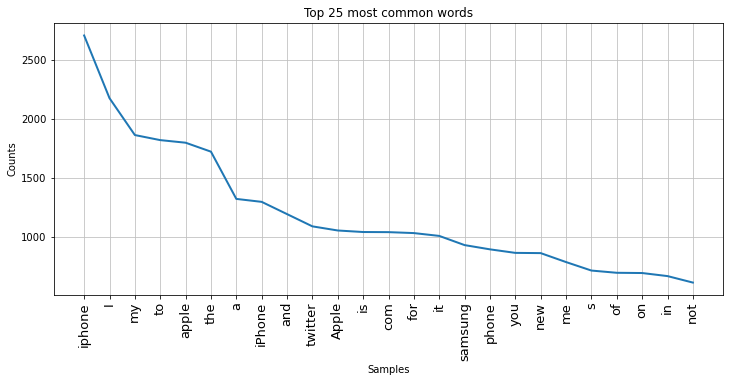

<AxesSubplot:title={'center':'Top 25 most common words'}, xlabel='Samples', ylabel='Counts'>

In [12]:
all_words = []
for line in list(text['cleaned_tweets']):
    words = line.split()
    for word in words:
        all_words.append(word)
all_words  

plt.figure(figsize=(12,5))
plt.title('Top 25 most common words')
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False) 

**Model building**

Bag of Words features

Here, frequency of every word in vocabulary is calculated and used to build the feature space.

In [13]:
vector=CountVectorizer()
BOW=vector.fit_transform(text.cleaned_tweets)
BOW.shape

(7920, 17669)

In [14]:
print(vector.get_feature_names()[:20])
(BOW.toarray())

['aa', 'aaaahhhhhhh', 'aag', 'aah', 'aalborg', 'aand', 'aapl', 'aarhus', 'aaron', 'aaronbrandt', 'aarp', 'aarrrggghhhh', 'aashamsakal', 'aaydojbfkq', 'aayp', 'ab', 'abah', 'abajournal', 'abareta', 'abay']


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [15]:
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(BOW,text['label'],test_size=0.3,random_state=42) 

### Train Logistic Regression

In [16]:
lr = LogisticRegression()           #instantiate model

lr.fit(xtrain_bow, ytrain)          #training model

prediction = lr.predict(xvalid_bow) #predicting on validation set

f1_score(yvalid, prediction)        #calculating f1 score

0.7655502392344498

### Train Naive Bayes

In [19]:
from sklearn.naive_bayes import MultinomialNB
naive_clf=MultinomialNB()
naive_clf.fit(xtrain_bow, ytrain)

prediction = naive_clf.predict(xvalid_bow) #predicting on validation set

f1_score(yvalid, prediction) 

0.8146143437077131